## Text classification using Neural Networks, Gensim and Spacy

The goal of this notebook is to learn to use Neural Networks for text classification.

In this notebook, we will:
- Train a shallow model with learning embeddings
- Download pre-trained embeddings from FastTextAi
- Use these pre-trained embeddings

However keep in mind:
- Deep Learning can be better on text classification that simpler ML techniques, but only on very large datasets and well designed/tuned models.
- We won't be using the most efficient (in terms of computing) techniques, as Keras is good for prototyping but rather inefficient for training small embedding models on text.
- The following projects can replicate similar word embedding models much more efficiently: [word2vec](https://github.com/dav/word2vec) and [gensim's word2vec](https://radimrehurek.com/gensim/models/word2vec.html)   (self-supervised learning only), [fastText](https://github.com/facebookresearch/fastText) (both supervised and self-supervised learning), [Vowpal Wabbit](https://github.com/JohnLangford/vowpal_wabbit/wiki) (supervised learning).
- Plain shallow sparse TF-IDF bigrams features without any embedding and Logistic Regression or Multinomial Naive Bayes is often competitive in small to medium datasets.


### Sentipolc 2016

It is the intention of the organizers to promote the construction of a shared dataset for both Sentipolc and the Named Entity rEcognition and Linking in Italian Tweets (NEEL-IT) Evalita 2016 task. Indeed, interest in entity-liking in Twitter is gaining increasing attention, as well as aspect-based sentiment analysis. In a world where e-commerce is part of our everyday life and social media platforms are regarded as new channels for marketing and for fostering trust of potential customers, such great interest in opinion mining from Twitter isn’t surprising. In this scenario, it is crucial to be able to mine opinions about specific aspects of objects and named entities. Therefore, we believe that besides the traditional task on message-level polarity classification, in the future editions of Evalita special focus should be given to entity-based sentiment analysis.
The use of common data for the Sentipolc and NEEL-IT is a first step towards the long-term goal of enabling participants to develop end-to-end system from entity linking to entity-based sentiment analysis. http://www.di.unito.it/~tutreeb/sentipolc-evalita16/data.html

In [54]:
!wget http://www.di.uniba.it/~swap/sentipolc/sentipolc16_train.csv
!wget http://www.di.uniba.it/~swap/sentipolc/sentipolc16_test.csv

--2023-12-11 09:15:19--  http://www.di.uniba.it/~swap/sentipolc/sentipolc16_train.csv
Resolving www.di.uniba.it (www.di.uniba.it)... 193.204.187.10
Connecting to www.di.uniba.it (www.di.uniba.it)|193.204.187.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1028257 (1004K) [text/plain]
Saving to: ‘sentipolc16_train.csv.3’

sentipolc16_train.c 100%[===================>]   1004K   888KB/s    in 1.1s    

2023-12-11 09:15:22 (888 KB/s) - ‘sentipolc16_train.csv.3’ saved [1028257/1028257]

--2023-12-11 09:15:22--  http://www.di.uniba.it/~swap/sentipolc/sentipolc16_test.csv
Resolving www.di.uniba.it (www.di.uniba.it)... 193.204.187.10
Connecting to www.di.uniba.it (www.di.uniba.it)|193.204.187.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 327873 (320K) [text/plain]
Saving to: ‘sentipolc16_test.csv.3’

sentipolc16_test.cs 100%[===================>] 320.19K   378KB/s    in 0.8s    

2023-12-11 09:15:23 (378 KB/s) - ‘sentipolc16_test.csv.3

In [55]:
import numpy as np
import pandas as pd

train= pd.read_csv('sentipolc16_train.csv')
test = pd.read_csv('sentipolc16_test.csv')

In [56]:
train

,idtwitter,subj,opos,oneg,iro,lpos,lneg,top,text
0,122449983151669248,1,0,1,0,0,1,1,Intanto la partita per Via Nazionale si compli...
1,125485104863780865,1,0,1,0,0,1,1,"False illusioni, sgradevoli realtà Mario Monti..."
2,125513454315507712,1,0,1,0,0,1,1,"False illusioni, sgradevoli realtà #editoriale..."
3,125524238290522113,1,0,1,0,0,1,1,Mario Monti: Berlusconi risparmi all'Italia il...
4,125527933224886272,1,0,1,0,0,1,1,Mario Monti: Berlusconi risparmi all'Italia il...
...,...,...,...,...,...,...,...,...,...
7405,135136897000415233,1,1,0,1,1,1,1,"che ci frega di mario monti, noi abbiamo mario..."
7406,143471916534087680,1,1,0,1,1,0,1,Strepitoso il titolo in prima di Libero sul go...
7407,153955345411219456,1,0,1,1,1,0,1,"@nataliacavalli Consolati, il governo #Monti h..."
7408,190835515552047104,1,1,0,1,1,1,0,"@SheisCandida beh, beate loro! Io nn possiedo ..."


In [57]:
sample_idx = 1000
print(train["text"][sample_idx])

L'abuso della parola super per i ministri del governo #Monti è il segno di quanto in Italia si fosse(sia) persa la concezione del normale 


In [58]:
target_classes = train["opos"]

target_id = train["opos"][sample_idx]
print("Class of previous message:", target_id)

Class of previous message: 0


Here are all the possible classes:

In [59]:
target_classes

0       0
1       0
2       0
3       0
4       0
       ..
7405    1
7406    1
7407    0
7408    1
7409    1
Name: opos, Length: 7410, dtype: int64

### Preprocessing text for the (supervised) CBOW model

We will implement a simple classification model in Keras. Raw text requires (sometimes a lot of) preprocessing.

The following cells uses Keras to preprocess text:
- using a tokenizer. You may use different tokenizers (from scikit-learn, NLTK, custom Python function etc.). This converts the texts into sequences of indices representing the `20000` most frequent words
- sequences have different lengths, so we pad them (add 0s at the end until the sequence is of length `1000`)
- we convert the output classes as 1-hot encodings

In [60]:
from keras.preprocessing.text import Tokenizer

MAX_NB_WORDS = 20000

# get the raw text data
texts_train = train["text"]
texts_test =test["text"]

# finally, vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer(nb_words=MAX_NB_WORDS, char_level=False)
tokenizer.fit_on_texts(texts_train)


sequences = tokenizer.texts_to_sequences(texts_train)
sequences_test = tokenizer.texts_to_sequences(texts_test)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/text.py:246: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn(


Found 21234 unique tokens.


Tokenized sequences are converted to list of token ids (with an integer code):

In [61]:
sequences[0]

[557,
 11,
 1081,
 14,
 47,
 651,
 22,
 6520,
 4070,
 111,
 10,
 904,
 34,
 33,
 15,
 1,
 7,
 5,
 6,
 6521,
 47,
 977]

The tokenizer object stores a mapping (vocabulary) from word strings to token ids that can be inverted to reconstruct the original message (without formatting):

In [62]:
type(tokenizer.word_index), len(tokenizer.word_index)

(dict, 21234)

In [63]:
index_to_word = dict((i, w) for w, i in tokenizer.word_index.items())

In [64]:
texts_train[0]

'Intanto la partita per Via Nazionale si complica. #Saccomanni dice che "mica tutti sono Mario #Monti" http://t.co/xPtNz4X7 via @linkiesta'

In [65]:
" ".join([index_to_word[i] for i in sequences[0]])

'intanto la partita per via nazionale si complica saccomanni dice che mica tutti sono mario monti http t co xptnz4x7 via linkiesta'

Let's have a closer look at the tokenized sequences:

In [66]:
seq_lens = [len(s) for s in sequences]
print("average length: %0.1f" % np.mean(seq_lens))
print("max length: %d" % max(seq_lens))

average length: 16.0
max length: 40


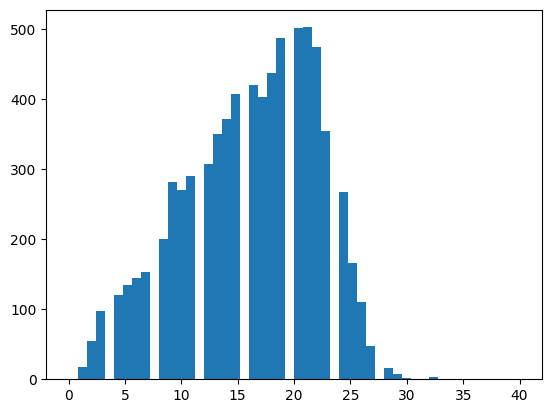

In [67]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.hist(seq_lens, bins=50);

Let's zoom on the distribution of regular sized posts. The vast majority of the posts have less than 30 symbols:

Let's truncate and pad all the sequences to 25 symbols to build the training set:

In [68]:
from keras.utils import pad_sequences


MAX_SEQUENCE_LENGTH = 25

# pad sequences with 0s
x_train = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH,padding='post')
x_test = pad_sequences(sequences_test, maxlen=MAX_SEQUENCE_LENGTH,padding='post')

print('Shape of data tensor:', x_train.shape)
print('Shape of data test tensor:', x_test.shape)

Shape of data tensor: (7410, 25)
Shape of data test tensor: (2000, 25)


In [69]:
x_train[0]

array([ 557,   11, 1081,   14,   47,  651,   22, 6520, 4070,  111,   10,
        904,   34,   33,   15,    1,    7,    5,    6, 6521,   47,  977,
          0,    0,    0], dtype=int32)

In [70]:
from tensorflow.keras.utils import to_categorical
y_train = train["opos"]
y_test = test["opos"]

y_train = to_categorical(np.asarray(y_train))
print('Shape of label tensor:', y_train.shape)

Shape of label tensor: (7410, 2)


In [71]:
y_train

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [0., 1.],
       [0., 1.]], dtype=float32)

### A simple supervised model in Keras

The following computes a very simple model:

<img src="https://m2dsupsdlclass.github.io/lectures-labs/slides/06_deep_nlp/images/fasttext.svg" style="width: 600px;" />

- Build an embedding layer mapping each word to a vector representation
- Compute the vector representation of all words in each sequence and average them
- Add a dense layer to output 20 classes (+ softmax)

In [72]:
from keras.layers import Dense, Input, Flatten
from keras.layers import GlobalAveragePooling1D, Embedding
from keras.models import Model

EMBEDDING_DIM = 50
N_CLASSES = 2

# input: a sequence of MAX_SEQUENCE_LENGTH integers
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')

embedded_sequences = Embedding(MAX_NB_WORDS, EMBEDDING_DIM,
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)(sequence_input)

average = GlobalAveragePooling1D()(embedded_sequences)
predictions = Dense(N_CLASSES, activation='softmax')(average)

model = Model(sequence_input, predictions)

model.compile(loss='categorical_crossentropy',
              optimizer='adam', metrics=['acc'])

In [73]:
history=model.fit(x_train, y_train, validation_split=0.1,
          epochs=10, batch_size=128, verbose=2)

Epoch 1/10
53/53 - 11s - loss: 0.6386 - acc: 0.7138 - val_loss: 0.5420 - val_acc: 0.7989 - 11s/epoch - 213ms/step
Epoch 2/10
53/53 - 5s - loss: 0.5829 - acc: 0.7149 - val_loss: 0.5142 - val_acc: 0.7989 - 5s/epoch - 90ms/step
Epoch 3/10
53/53 - 4s - loss: 0.5496 - acc: 0.7154 - val_loss: 0.5126 - val_acc: 0.8003 - 4s/epoch - 66ms/step
Epoch 4/10
53/53 - 3s - loss: 0.5167 - acc: 0.7239 - val_loss: 0.5243 - val_acc: 0.8165 - 3s/epoch - 54ms/step
Epoch 5/10
53/53 - 2s - loss: 0.4827 - acc: 0.7575 - val_loss: 0.5124 - val_acc: 0.8016 - 2s/epoch - 29ms/step
Epoch 6/10
53/53 - 1s - loss: 0.4450 - acc: 0.7860 - val_loss: 0.5081 - val_acc: 0.7908 - 1s/epoch - 21ms/step
Epoch 7/10
53/53 - 1s - loss: 0.4043 - acc: 0.8217 - val_loss: 0.5065 - val_acc: 0.7814 - 1s/epoch - 20ms/step
Epoch 8/10
53/53 - 1s - loss: 0.3635 - acc: 0.8572 - val_loss: 0.5167 - val_acc: 0.7706 - 929ms/epoch - 18ms/step
Epoch 9/10
53/53 - 1s - loss: 0.3249 - acc: 0.8871 - val_loss: 0.5148 - val_acc: 0.7638 - 925ms/epoch - 17

**Exercice**
 - compute model evaluation on test set

##Evaluation

In [74]:
output_test = model.predict(x_test)

test_classes = np.argmax(output_test, axis=-1)

print(test_classes)

63/63 [==============================] - 0s 2ms/step
[0 0 0 ... 0 0 0]


In [75]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("test accuracy:", accuracy_score(test_classes,y_test))
print("test precision:", precision_score(test_classes,y_test,average='macro'))
print("test recall:", recall_score(test_classes,y_test,average='macro'))
print("test F1:", f1_score(test_classes,y_test,average='macro'))

test accuracy: 0.841
test precision: 0.6242552956751986
test recall: 0.7316939890710382
test F1: 0.6496863701559226


##Complex Models

### Building more complex models

**Exercise**
- From the previous template, build more complex models using:
  - 1d convolution and 1d maxpooling. Note that you will still need a GloabalAveragePooling or Flatten after the convolutions
  - Recurrent neural networks through LSTM (you will need to reduce sequence length before)
  
  
<img src="https://m2dsupsdlclass.github.io/lectures-labs/slides/06_deep_nlp/images/unrolled_rnn_one_output_2.svg" style="width: 600px;" />

**Bonus**
- You may try different architectures with:
  - more intermediate layers, combination of dense, conv, recurrent
  - different recurrent (GRU, RNN)
  - bidirectional LSTMs

Note: The goal is to build working models rather than getting better test accuracy. To achieve much better results, we'd need more computation time and data quantity. Build your model, and verify that they converge to OK results.

In [76]:
# solutions lstm.py
from keras.layers import LSTM, Conv1D, MaxPooling1D, Embedding, Flatten, Dense, Dropout
EMBEDDING_DIM = 300

In [77]:
# input: a sequence of MAX_SEQUENCE_LENGTH integers
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')

embedded_sequences = Embedding(MAX_NB_WORDS, EMBEDDING_DIM,
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True) (sequence_input)

# LSTM layer with a hidden size of 64
x = LSTM(64,dropout=0.2)(embedded_sequences)
x = Dense(30) (x)
predictions = Dense(2, activation='softmax')(x)

model = Model(sequence_input, predictions)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

# You will get large speedups with these models by using a GPU
# The model might take a lot of time to converge, and even more
# if you add dropout (needed to prevent overfitting)


In [78]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 25)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 25, 300)           6000000   
                                                                 
 lstm (LSTM)                 (None, 64)                93440     
                                                                 
 dense_1 (Dense)             (None, 30)                1950      
                                                                 
 dense_2 (Dense)             (None, 2)                 62        
                                                                 
Total params: 6095452 (23.25 MB)
Trainable params: 6095452 (23.25 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [79]:
model.fit(x_train,y_train,epochs=4, validation_split=0.1,
          batch_size=128)

Epoch 1/4
53/53 [==============================] - 13s 159ms/step - loss: 0.5966 - acc: 0.7066 - val_loss: 0.4742 - val_acc: 0.7922
Epoch 2/4
53/53 [==============================] - 5s 91ms/step - loss: 0.3911 - acc: 0.8265 - val_loss: 0.6766 - val_acc: 0.6680
Epoch 3/4
53/53 [==============================] - 3s 63ms/step - loss: 0.1577 - acc: 0.9436 - val_loss: 0.7374 - val_acc: 0.7382
Epoch 4/4
53/53 [==============================] - 3s 48ms/step - loss: 0.0696 - acc: 0.9774 - val_loss: 0.7651 - val_acc: 0.7409


In [80]:
output_test = model.predict(x_test)
test_casses = np.argmax(output_test, axis=-1)

print("test accuracy:", accuracy_score(test_casses,y_test))
print("test precision:", precision_score(test_casses,y_test,average='macro'))
print("test recall:", recall_score(test_casses,y_test,average='macro'))
print("test F1:", f1_score(test_casses,y_test,average='macro'))


63/63 [==============================] - 0s 2ms/step
test accuracy: 0.782
test precision: 0.6107954545454546
test recall: 0.6171957054498775
test F1: 0.6137491141034728


In [81]:
# %load solutions/conv1d.py
from keras.layers import Conv1D, MaxPooling1D, Flatten

sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = Embedding(MAX_NB_WORDS, EMBEDDING_DIM,
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True) (sequence_input)

# A 1D convolution with 128 output channels
x = Conv1D(128, 2, activation='relu')(embedded_sequences)
# MaxPool divides the length of the sequence by 5
x = MaxPooling1D(2)(x)
# A 1D convolution with 64 output channels
x = Conv1D(64, 2, activation='relu')(x)
# MaxPool divides the length of the sequence by 5
x = MaxPooling1D(2)(x)
x = Flatten()(x)

predictions = Dense(2, activation='softmax')(x)

model = Model(sequence_input, predictions)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])


In [82]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 25)]              0         
                                                                 
 embedding_2 (Embedding)     (None, 25, 300)           6000000   
                                                                 
 conv1d (Conv1D)             (None, 24, 128)           76928     
                                                                 
 max_pooling1d (MaxPooling1  (None, 12, 128)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 11, 64)            16448     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 5, 64)             0         
 g1D)                                                      

In [83]:
model.fit(x_train,y_train,epochs=4, validation_split=0.1,
          batch_size=128)

Epoch 1/4
53/53 [==============================] - 14s 113ms/step - loss: 0.5903 - acc: 0.7141 - val_loss: 0.5193 - val_acc: 0.7989
Epoch 2/4
53/53 [==============================] - 3s 59ms/step - loss: 0.4489 - acc: 0.7772 - val_loss: 0.4981 - val_acc: 0.7395
Epoch 3/4
53/53 [==============================] - 3s 56ms/step - loss: 0.1512 - acc: 0.9445 - val_loss: 0.6739 - val_acc: 0.6842
Epoch 4/4
53/53 [==============================] - 3s 45ms/step - loss: 0.0263 - acc: 0.9951 - val_loss: 0.7384 - val_acc: 0.7152


In [84]:
output_test = model.predict(x_test)
test_casses = np.argmax(output_test, axis=-1)

print("test accuracy:", accuracy_score(test_casses,y_test))
print("test precision:", precision_score(test_casses,y_test,average='macro'))
print("test recall:", recall_score(test_casses,y_test,average='macro'))
print("test F1:", f1_score(test_casses,y_test,average='macro'))

63/63 [==============================] - 0s 3ms/step
test accuracy: 0.7745
test precision: 0.6129468225948809
test recall: 0.6121965837578663
test F1: 0.6125680851456801


In [85]:
from keras.layers import LSTM, Conv1D, MaxPooling1D

# input: a sequence of MAX_SEQUENCE_LENGTH integers
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = Embedding(MAX_NB_WORDS, EMBEDDING_DIM,
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True) (sequence_input)

# 1D convolution with 64 output channels
x = Conv1D(128, 2)(embedded_sequences)
# MaxPool divides the length of the sequence by 5
x = MaxPooling1D(2)(x)
# LSTM layer with a hidden size of 64
x = LSTM(64)(x)
x = Dense(30) (x)
predictions = Dense(2, activation='softmax')(x)

model = Model(sequence_input, predictions)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])


In [86]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 25)]              0         
                                                                 
 embedding_3 (Embedding)     (None, 25, 300)           6000000   
                                                                 
 conv1d_2 (Conv1D)           (None, 24, 128)           76928     
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 12, 128)           0         
 g1D)                                                            
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense_4 (Dense)             (None, 30)                1950      
                                                           

In [87]:
model.fit(x_train, y_train, validation_split=0.1,
          epochs=5, batch_size=128)

Epoch 1/5
53/53 [==============================] - 9s 109ms/step - loss: 0.5886 - acc: 0.7176 - val_loss: 0.4907 - val_acc: 0.8057
Epoch 2/5
53/53 [==============================] - 3s 67ms/step - loss: 0.3688 - acc: 0.8358 - val_loss: 0.6896 - val_acc: 0.6653
Epoch 3/5
53/53 [==============================] - 3s 48ms/step - loss: 0.1094 - acc: 0.9601 - val_loss: 1.0548 - val_acc: 0.6491
Epoch 4/5
53/53 [==============================] - 2s 48ms/step - loss: 0.0275 - acc: 0.9918 - val_loss: 0.8924 - val_acc: 0.7611
Epoch 5/5
53/53 [==============================] - 2s 37ms/step - loss: 0.0135 - acc: 0.9958 - val_loss: 1.1993 - val_acc: 0.6829


In [88]:
output_test = model.predict(x_test)
test_casses = np.argmax(output_test, axis=-1)

print("test accuracy:", accuracy_score(test_casses,y_test))
print("test precision:", precision_score(test_casses,y_test,average='macro'))
print("test recall:", recall_score(test_casses,y_test,average='macro'))
print("test F1:", f1_score(test_casses,y_test,average='macro'))


63/63 [==============================] - 1s 2ms/step
test accuracy: 0.7695
test precision: 0.6423074801412181
test recall: 0.6237529438395613
test F1: 0.631107776944236


In [89]:
from sklearn.metrics import confusion_matrix
confusion_matrix= confusion_matrix(test_casses, y_test)
print(confusion_matrix)


[[1382  195]
 [ 266  157]]


In [90]:
from sklearn.metrics import classification_report
print(classification_report(test_casses, y_test))

              precision    recall  f1-score   support

           0       0.84      0.88      0.86      1577
           1       0.45      0.37      0.41       423

    accuracy                           0.77      2000
   macro avg       0.64      0.62      0.63      2000
weighted avg       0.76      0.77      0.76      2000



### Loading pre-trained embeddings



In [91]:
import os.path as op
import gzip
import shutil
from urllib.request import urlretrieve
# Get pretrained FastText Embeddings
URL_REPRESENTATIONS = "https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.it.300.vec.gz"
ZIP_REPRESENTATIONS = "cc.it.300.vec.gz"
FILE_REPRESENTATIONS = "cc.it.300.vec"

if not op.exists(ZIP_REPRESENTATIONS):
    print('Downloading from %s to %s...' % (URL_REPRESENTATIONS, ZIP_REPRESENTATIONS))
    urlretrieve(URL_REPRESENTATIONS, './' + ZIP_REPRESENTATIONS)

with gzip.open(ZIP_REPRESENTATIONS, 'rb') as f_in:
    with open(FILE_REPRESENTATIONS, 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

In [92]:
embeddings_index = {}
embeddings_vectors = []
f = open('cc.it.300.vec', 'rb')

word_idx = 0
i = 0
for line in f:
    if i != 0:
      values = line.decode('utf-8').split()
      word = values[0]
      vector = np.asarray(values[1:], dtype='float32')
      embeddings_index[word] = word_idx
      embeddings_vectors.append(vector)
      word_idx = word_idx + 1
    i = i+1
f.close()

inv_index = {v: k for k, v in embeddings_index.items()}
print("found %d different words in the file" % word_idx)

found 2000000 different words in the file


In [93]:
# Stack all embeddings in a large numpy array
embeddings = np.vstack(embeddings_vectors)

print(embeddings.shape)

(2000000, 300)


In [94]:
def get_emb(word):
    idx = embeddings_index.get(word)
    if idx is None:
        return None
    else:
        return embeddings[idx]

In [95]:
get_emb("ci")

array([ 8.8300e-02, -5.6700e-02, -4.2840e-01, -8.7800e-02,  1.9370e-01,
       -1.3990e-01, -5.3600e-02, -1.0140e-01,  3.3660e-01,  2.8670e-01,
        1.0720e-01,  6.0500e-02,  4.0150e-01,  1.0830e-01,  6.1400e-02,
        2.3900e-02,  9.8700e-02, -2.3500e-02, -3.1700e-02,  3.4000e-03,
        1.3490e-01, -2.3930e-01, -1.1300e-02, -5.7200e-02,  1.2720e-01,
       -6.2200e-02,  1.6000e-02,  8.6800e-02,  1.2330e-01,  2.2320e-01,
        3.2500e-02, -6.3400e-02, -9.6000e-02, -5.5000e-03, -7.1200e-02,
        3.0200e-02, -1.8740e-01, -3.7200e-02, -1.9600e-02,  9.5100e-02,
        1.2500e-02,  1.1000e-02,  1.7210e-01, -1.6990e-01, -1.2660e-01,
        6.0000e-02,  1.9790e-01,  9.4300e-02, -1.8730e-01,  1.2780e-01,
       -7.6600e-02,  8.3000e-02,  5.2000e-03,  1.5920e-01,  3.4600e-02,
       -1.7000e-01, -2.3270e-01,  1.3280e-01, -2.0480e-01, -7.5900e-02,
        1.7250e-01,  1.8630e-01,  1.6310e-01, -4.7000e-02, -1.4840e-01,
        2.4350e-01, -2.1800e-02,  2.1400e-02,  1.6900e-01, -4.44

### Finding most similar words

**Exercice**

Build a function to find most similar words, given a word as query:
- lookup the vector for the query word in the Glove index;
- compute the cosine similarity between a word embedding and all other words;
- display the top 10 most similar words.

**Bonus**

Change your function so that it takes multiple words as input (by averaging them)

In [96]:
# %load solutions/most_similar.py
def most_similar(words, topn=10):
    query_emb = 0
    # If we have a list of words instead of one word
    # (bonus question)
    if type(words) == list:
        for word in words:
            query_emb += get_emb(word)
    else:
        query_emb = get_emb(words)

    #query_emb = query_emb / np.linalg.norm(query_emb)

    # Large numpy vector with all similarities
    # between emb and all other words
    similarities = np.dot(embeddings, query_emb)

    # topn most similar indexes
    idxs = np.argsort(similarities)[::-1][:topn]

    # pretty return with word and similarity
    return [(inv_index[idx], similarities[idx]) for idx in idxs]


In [97]:
most_similar("cpu")

[('cpu', 7.150271),
 ('i7', 6.539628),
 ('i5', 5.7718916),
 ('R0', 5.4669394),
 ('CPU', 5.465336),
 ('gpu', 5.425723),
 ('ram', 5.3928967),
 ('kJ', 5.143676),
 ('nm', 5.0835543),
 ('gb', 4.7928314)]

In [98]:
most_similar("mela")

[('mela', 2.3820162),
 ('uva', 1.885606),
 ('bt', 1.7568856),
 ('3g', 1.7126958),
 ('Tè', 1.7035183),
 ('mele', 1.5696958),
 ('pomo', 1.5258517),
 ('M8', 1.5124705),
 ('Mela', 1.4639683),
 ('yi', 1.4282726)]

In [99]:
most_similar("latte")

[('ml', 1.614389),
 ('tè', 1.5165406),
 ('té', 1.4574687),
 ('UHT', 1.4431446),
 ('µg', 1.3956451),
 ('latte', 1.3748871),
 ('mL', 1.3286628),
 ('pH', 1.1744329),
 ('soia', 1.1358578),
 ('Bf', 1.1308407)]

### Using pre-trained embeddings in our model

We want to use these pre-trained embeddings for transfer learning. This process is rather similar than transfer learning in image recognition: the features learnt on words might help us bootstrap the learning process, and increase performance if we don't have enough training data.
- We initialize embedding matrix from the model with embeddings:
 - take all words from our 20 Newgroup vocabulary (`MAX_NB_WORDS = 20000`), and look up their embedding
 - place the Glove embedding at the corresponding index in the matrix
 - if the word is not in the vocabulary, we only place zeros in the matrix
- We may fix these embeddings or fine-tune them

In [100]:
EMBEDDING_DIM = 300

# prepare embedding matrix
nb_words_in_matrix = 0
nb_words = min(MAX_NB_WORDS, len(word_index))
embedding_matrix = np.zeros((nb_words, EMBEDDING_DIM))

for word, i in word_index.items():
    if i >= MAX_NB_WORDS:
        continue
    embedding_vector = get_emb(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        nb_words_in_matrix = nb_words_in_matrix + 1

print("added %d words in the embedding matrix" % nb_words_in_matrix)

added 13368 words in the embedding matrix


In [101]:
print(embedding_matrix.shape)

(20000, 300)


Build a layer with pre-trained embeddings:

In [102]:
pretrained_embedding_layer = Embedding(
    MAX_NB_WORDS, EMBEDDING_DIM,
    weights=[embedding_matrix],
    input_length=MAX_SEQUENCE_LENGTH
)

### A model with pre-trained Embeddings

Average word embeddings pre-trained with Glove / Word2Vec usually works suprisingly well. However, when averaging more than `10-15` words, the resulting vector becomes too noisy and classification performance is degraded.

In [103]:
from keras.layers import LSTM, Conv1D, MaxPooling1D, Flatten
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
emb = Embedding(MAX_NB_WORDS, EMBEDDING_DIM,weights=[embedding_matrix],input_length=MAX_SEQUENCE_LENGTH)(sequence_input)

rec = LSTM(units=128,return_sequences = True)(emb)
flat = Flatten()(rec)
dense = Dense(200,activation='sigmoid') (flat)
predictions = Dense(N_CLASSES, activation='softmax')(dense)

model = Model(sequence_input, predictions)

# We don't want to fine-tune embeddings
model.layers[1].trainable=False

model.compile(loss='categorical_crossentropy',
              optimizer='adam', metrics=['acc'])

In [104]:
from keras.utils import plot_model
#plot_model(model)
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 25)]              0         
                                                                 
 embedding_5 (Embedding)     (None, 25, 300)           6000000   
                                                                 
 lstm_2 (LSTM)               (None, 25, 128)           219648    
                                                                 
 flatten_1 (Flatten)         (None, 3200)              0         
                                                                 
 dense_6 (Dense)             (None, 200)               640200    
                                                                 
 dense_7 (Dense)             (None, 2)                 402       
                                                                 
Total params: 6860250 (26.17 MB)
Trainable params: 860250 (

In [105]:
model.fit(x_train, y_train, validation_split=0.1,
          epochs=10, batch_size=128)

# Note, on this type of task, this technique will
# degrade results as we train much less parameters
# and we average a large number pre-trained embeddings.
# You will notice much less overfitting then!
# Using convolutions / LSTM will help
# It is also advisable to treat seperately pre-trained
# embeddings and words out of vocabulary.

Epoch 1/10
53/53 [==============================] - 7s 21ms/step - loss: 0.5748 - acc: 0.7052 - val_loss: 0.5493 - val_acc: 0.7314
Epoch 2/10
53/53 [==============================] - 1s 10ms/step - loss: 0.5208 - acc: 0.7577 - val_loss: 0.6129 - val_acc: 0.6856
Epoch 3/10
53/53 [==============================] - 1s 10ms/step - loss: 0.4981 - acc: 0.7706 - val_loss: 0.5272 - val_acc: 0.7652
Epoch 4/10
53/53 [==============================] - 0s 9ms/step - loss: 0.4758 - acc: 0.7823 - val_loss: 0.5628 - val_acc: 0.7571
Epoch 5/10
53/53 [==============================] - 0s 9ms/step - loss: 0.4556 - acc: 0.7932 - val_loss: 0.5133 - val_acc: 0.7625
Epoch 6/10
53/53 [==============================] - 1s 10ms/step - loss: 0.4399 - acc: 0.8037 - val_loss: 0.7027 - val_acc: 0.6775
Epoch 7/10
53/53 [==============================] - 0s 8ms/step - loss: 0.4147 - acc: 0.8160 - val_loss: 0.5510 - val_acc: 0.7571
Epoch 8/10
53/53 [==============================] - 0s 9ms/step - loss: 0.3986 - acc: 

In [106]:
output_test = model.predict(x_test)
test_casses = np.argmax(output_test, axis=-1)

print("test accuracy:", accuracy_score(test_casses,y_test))
print("test precision:", precision_score(test_casses,y_test,average='macro'))
print("test recall:", recall_score(test_casses,y_test,average='macro'))
print("test F1:", f1_score(test_casses,y_test,average='macro'))

63/63 [==============================] - 1s 5ms/step
test accuracy: 0.6705
test precision: 0.6179804721977052
test recall: 0.575979018067775
test F1: 0.5710516492217907


### Reality check

On small/medium datasets, simpler classification methods usually perform better, and are much more efficient to compute. Here are two resources to go further:
- Naive Bayes approach, using scikit-learn http://scikit-learn.org/stable/datasets/twenty_newsgroups.html
- Alec Radford (OpenAI) gave a very interesting presentation, showing that you need a VERY large dataset to have real gains from GRU/LSTM in text classification https://www.slideshare.net/odsc/alec-radfordodsc-presentation

However, when looking at features, one can see that classification using simple methods isn't very robust, and won't generalize well to slightly different domains (e.g. forum posts => emails)

Note: Implementation in Keras for text is very slow due to python overhead and lack of hashing techniques. The fastText implementation https://github.com/facebookresearch/fasttext is much, much faster.

## Going further

- Compare pre-trained embeddings vs specifically trained embeddings
- Train your own wordvectors in any language using [gensim's word2vec](https://radimrehurek.com/gensim/models/word2vec.html)
- Check [Keras Examples](https://github.com/fchollet/keras/tree/master/examples) on `imdb` sentiment analysis
- Use GLOVE over Gensim and give it a try on the classification example in its repository.
- Try Different pre-processing operations using SpaCy or Ekphrasis (see example below), i.e. stopword removal, stemming, etc.
